In [17]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import tqdm


class FlowModel(nn.Module):
    def __init__(self, num_hid):
        super().__init__()
        # We encoded the current state as binary vector, for each patch the associated
        # dimension is either 0 or 1 depending on the absence or precense of that patch.
        # Therefore the input dimension is 6 for the 6 patches.
        self.mlp = nn.Sequential(
            nn.Linear(9, num_hid),
            nn.ReLU(),  # Changed to ReLU
            nn.Linear(num_hid, num_hid),  # Added an extra hidden layer
            nn.ReLU(),  # Activation for the new hidden layer
            nn.Linear(num_hid, 9),
        )

    def forward(self, x):
        # We take the exponential to get positive numbers, since flows must be positive,
        # and multiply by (1 - x) to give 0 flow to actions we know we can't take
        # (in this case, x[i] is 1 if a feature is already there, so we know we
        # can't add it again).
        F = self.mlp(x).exp() * (1 - x) * (1 + x)
        return F


class TBModel(nn.Module):
    def __init__(self, num_hid):
        super().__init__()
        # The input dimension is 6 for the 6 patches.
        self.mlp = nn.Sequential(
            nn.Linear(9, num_hid),
            nn.LeakyReLU(),
            # We now output 12 numbers, 6 for P_F and 6 for P_B
            nn.Linear(num_hid, 18),
        )
        # log Z is just a single number
        self.logZ = nn.Parameter(torch.ones(1))

    def forward(self, x):
        logits = self.mlp(x)
        # Slice the logits, and mask invalid actions (since we're predicting
        # log-values), we use -100 since exp(-100) is tiny, but we don't want -inf)
        P_F = logits[..., :9] * (1 - x) * (1 + x) + x * x * -100
        P_B = logits[..., 9:] * x * x + (1 + x) * (1 - x) * -100
        return P_F, P_B


def encode_tictactoe_board(board):
    """
    Encode a Tic-Tac-Toe board as a 1D torch tensor.

    Args:
        board (list of list of str): A 3x3 list representing the board, where each element is 'X', 'O', or ' '.

    Returns:
        torch.Tensor: A 1D tensor with values 1, -1, or 0.
    """
    mapping = {"X": 1, "O": -1, " ": 0}
    tensor_board = torch.tensor(
        [mapping[cell] for row in board for cell in row], dtype=torch.float
    )
    return tensor_board


import torch


def decode_tictactoe_tensor(tensor):
    """
    Decode a 1D torch tensor back into a Tic-Tac-Toe board.

    Args:
        tensor (torch.Tensor): A 1D tensor with values 1, -1, or 0.

    Returns:
        list of list of str: A 3x3 list representing the board, where each element is 'X', 'O', or ' '.
    """
    inverse_mapping = {1: "X", -1: "O", 0: " "}
    board = [
        [inverse_mapping[tensor[i * 3 + j].item()] for j in range(3)] for i in range(3)
    ]
    return board


def check_winner(board, player):
    """
    Check if the given player has won the game.

    Args:
        board (list of list of str): The Tic-Tac-Toe board.
        player (str): The player's symbol ('X' or 'O').

    Returns:
        bool: True if the player has won, False otherwise.
    """
    # Check rows, columns, and diagonals
    for i in range(3):
        if all(board[i][j] == player for j in range(3)) or all(
            board[j][i] == player for j in range(3)
        ):
            return True
    if all(board[i][i] == player for i in range(3)) or all(
        board[i][2 - i] == player for i in range(3)
    ):
        return True
    return False


def is_board_full(board):
    """
    Check if the board is full.

    Args:
        board (list of list of str): The Tic-Tac-Toe board.

    Returns:
        bool: True if the board is full, False otherwise.
    """
    return all(cell != " " for row in board for cell in row)


def reward_function(board, player):
    """
    Determine the reward for the given player based on the state of the board.

    Args:
        board (list of list of str): The Tic-Tac-Toe board.
        player (str): The player's symbol ('X' or 'O').

    Returns:
        int: The reward: 1 if the player won, -1 if lost, 0 if draw or the board is incomplete.
    """
    opponent = "O" if player == "X" else "X"

    if check_winner(board, player):
        return 3
    elif check_winner(board, opponent):
        return 1
    elif is_board_full(board):
        return 2
    else:
        return 0

In [2]:
def get_available_actions(encoded_board, player):
    """
    Get the available actions for the player on the given board.

    Args:
        encoded_board (torch.Tensor): A 1D tensor representing the encoded board state.
        player (str): The player's symbol ('X' or 'O').

    Returns:
        list of torch.Tensor: A list of 1D tensors representing the actions that the player can take.
    """
    # Find the positions of zeros in the tensor
    zero_positions = (encoded_board == 0).nonzero(as_tuple=True)[0]

    num = 1 if player == "X" else -1
    # Create the list of tensors
    result = []
    for pos in zero_positions:
        new_tensor = torch.zeros_like(encoded_board)
        new_tensor[pos] = num
        result.append(new_tensor)

    return result


def enumerate_parents(encoded_board, player, allow_bad_moves=False):
    """
    Enumerate all possible parent states of the given board state.

    Args:
        encoded_board (torch.Tensor): A 1D tensor representing the encoded board state.
        player (str): The player's symbol ('X' or 'O').

    Returns:
        list of torch.Tensor: A list of 1D tensors representing the parent states.
    """
    num = 1 if player == "X" else -1

    if allow_bad_moves:
        # a bad board can be either one where the player has a 2
        # or that it has more than 1 more X than O
        hasTwo = (encoded_board == 2).sum() > 0
        if hasTwo:
            # return the move that took us to this state
            parent_board = encoded_board.clone()
            parent_board[encoded_board == 2] = 1
            pos = (encoded_board == 2).nonzero(as_tuple=True)[0]
            return [parent_board], [pos]

        if (encoded_board == 1).sum() > (encoded_board == -1).sum() + 1:
            # for every square that has a 0, we can assume that it could have been a -1 that we added 1 to
            # so we can return all of those
            parent_boards = []
            parent_actions = []
            zero_positions = (encoded_board == 0).nonzero(as_tuple=True)[0]
            for pos in zero_positions:
                parent_board = encoded_board.clone()
                parent_board[pos] = -1
                parent_boards.append(parent_board)
                parent_actions.append(pos)

            return parent_boards, parent_actions

    # Find the positions of the player's moves in the tensor
    player_positions = (encoded_board == num).nonzero(as_tuple=True)[0]

    # Create the list of tensors
    result = []
    actions = []
    for pos in player_positions:
        new_tensor = encoded_board.clone()
        new_tensor[pos] = 0
        # action_taken = torch.zeros_like(encoded_board)
        # action_taken[pos] = num
        action_taken = pos
        result.append(new_tensor)
        actions.append(action_taken)

    return result, actions


def is_valid_action(encoded_board, action):
    """
    Check if the given action is valid on the board.

    Args:
        encoded_board (torch.Tensor): A 1D tensor representing the encoded board state.
        action (torch.Tensor): A 1D tensor representing the action to take.

    Returns:
        bool: True if the action is valid, False otherwise.
    """
    return encoded_board[action == 1] == 0

In [3]:
enumerate_parents(torch.tensor([1, 0, 0, 0, 0, 0, 0, 0, 0]), "X", allow_bad_moves=True)

([tensor([0, 0, 0, 0, 0, 0, 0, 0, 0])], [tensor(0)])

In [43]:
import random

initial_board = [[" ", " ", " "], [" ", " ", " "], [" ", " ", " "]]
encoded_initial_board = encode_tictactoe_board(initial_board)
board = encoded_initial_board
play = True

while play:
    player = "X"
    available_actions = get_available_actions(board, player)
    if len(available_actions) == 0:
        print("No available actions. Game is a draw.")
        break

    action = random.choice(available_actions)
    board = board + action

    hasWon = check_winner(decode_tictactoe_tensor(board), player)

    if hasWon:
        print("Player X has won")
        break

    player = "O"
    available_actions = get_available_actions(board, player)
    if len(available_actions) == 0:
        print("No available actions. Game is a draw.")
        break

    action = random.choice(available_actions)
    board = board + action

    hasWon = check_winner(decode_tictactoe_tensor(board), player)

    if hasWon:
        print("Player O has won")
        break

Player O has won


In [44]:
decode_tictactoe_tensor(board)

[['X', ' ', 'O'], ['X', 'O', ' '], ['O', 'X', ' ']]

In [47]:
# Instantiate model and optimizer
F_sa = FlowModel(64)
opt = torch.optim.Adam(F_sa.parameters(), 1e-3)
# Let's keep track of the losses and the faces we sample
losses = []
sampled_faces = []

minibatch_loss = 0

In [67]:
# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode.
logs = []
update_freq = 4
player = "X"
for episode in tqdm.tqdm(range(100_000), ncols=40):
    # Each episode starts with an empty board
    initial_board = [[" ", " ", " "], [" ", " ", " "], [" ", " ", " "]]
    encoded_initial_board = encode_tictactoe_board(initial_board)
    board = encoded_initial_board
    # Predict F(s, a)
    edge_flow_prediction = F_sa(board)
    play = True

    log = []
    while play:
        # The policy is just normalizing, and gives us the probability of each action

        policy = edge_flow_prediction / edge_flow_prediction.sum()
        # Sample the action
        action = Categorical(probs=policy).sample()
        action = torch.eye(9)[action]
        # "Go" to the next state
        new_board = board + action
        log.append((board, action, new_board, "X"))

        # Check if action is valid
        if not is_valid_action(board, action):
            # If the action is invalid, we set the reward to -1 and break
            reward = 0
            edge_flow_prediction = torch.zeros(9)
            parent_states, parent_actions = enumerate_parents(new_board, "X", True)
            # And compute the edge flows F(s, a) of each parent
            px = torch.stack([p for p in parent_states])
            pa = torch.tensor(parent_actions).long()
            parent_edge_flow_preds = F_sa(px)[torch.arange(len(parent_states)), pa]

            flow_mismatch = (
                parent_edge_flow_preds.sum() - edge_flow_prediction.sum() - reward
            ).pow(2)
            play = False
            log.append("invalid move")

        else:
            # Now we want to compute the loss, we'll first enumerate the parents
            parent_states, parent_actions = enumerate_parents(new_board, "X")
            # And compute the edge flows F(s, a) of each parent
            px = torch.stack([p for p in parent_states])
            pa = torch.tensor(parent_actions).long()
            parent_edge_flow_preds = F_sa(px)[torch.arange(len(parent_states)), pa]
            # Now we need to compute the reward and F(s, a) of the current state,
            # which is currently `new_state`
            reward = 0
            hasWon = check_winner(decode_tictactoe_tensor(new_board), "X")
            if hasWon:
                reward = 2
                edge_flow_prediction = torch.zeros(9)
                play = False
                log.append("X won")

            elif is_board_full(decode_tictactoe_tensor(new_board)):
                reward = 1
                edge_flow_prediction = torch.zeros(9)
                play = False
                log.append("draw")

            else:
                # now the opponent moves
                possibleMoves = get_available_actions(new_board, "O")
                opponentMove = random.choice(possibleMoves)
                new_board = new_board + opponentMove

                log.append((new_board, opponentMove, new_board, "O"))

                hasWon = check_winner(decode_tictactoe_tensor(new_board), "O")
                if hasWon:
                    reward = 0
                    edge_flow_prediction = torch.zeros(9)
                    play = False
                    log.append("O won")

                # If the board is full, the game is a draw
                if is_board_full(decode_tictactoe_tensor(new_board)):
                    reward = 1
                    edge_flow_prediction = torch.zeros(9)
                    play = False
                    log.append("draw")

            if play:
                # Now we need to compute the edge flows F(s, a) of the current state,
                # which is currently `new_state`
                edge_flow_prediction = F_sa(new_board)

            # The loss as per the equation above
            flow_mismatch = (
                parent_edge_flow_preds.sum() - edge_flow_prediction.sum() - reward
            ).pow(2)

        minibatch_loss += flow_mismatch  # Accumulate
        # Continue iterating
        board = new_board

    # We're done with the episode, add the face to the list, and if we are at an
    # update episode, take a gradient step.
    # logs.append(log)
    sampled_faces.append(board)
    if episode % update_freq == 0:
        losses.append(minibatch_loss.item())
        minibatch_loss.backward()
        opt.step()
        opt.zero_grad()
        minibatch_loss = 0

  0%|        | 0/100000 [00:00<?, ?it/s]


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [72]:
def find_best_move(moves, player="O"):
    best_move = None
    best_reward = -1
    for move in moves:
        new_board = board + move
        reward = reward_function(decode_tictactoe_tensor(new_board), player)
        if reward > best_reward:
            best_reward = reward
            best_move = move
    return best_move

In [79]:
board = torch.tensor([1.0, 1.0, 0.0, 0.0, -1.0, 1.0, -1.0, 0.0, 0.0])

In [81]:
possibleMoves = get_available_actions(new_board, "O")
find_best_move(possibleMoves, "O")

tensor([ 0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.])

In [99]:
import random
import numpy

# Instantiate model and optimizer
model = TBModel(512)
opt = torch.optim.Adam(model.parameters(), 3e-4)

# Let's keep track of the losses and the faces we sample
tb_losses = []
tb_sampled_faces = []
# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode.
minibatch_loss = 0
update_freq = 2

logZs = []
for episode in tqdm.tqdm(range(500_000), ncols=40):
    # Each episode starts with an "empty state"
    state = []
    # Predict P_F, P_B
    initial_board = [[" ", " ", " "], [" ", " ", " "], [" ", " ", " "]]
    encoded_initial_board = encode_tictactoe_board(initial_board)
    board = encoded_initial_board
    # Predict F(s, a)
    P_F_s, P_B_s = model(board)
    play = True

    total_P_F = 0
    total_P_B = 0
    n = 10
    while play and n > 0:
        n -= 1
        # Here P_F is logits, so we want the Categorical to compute the softmax for us
        cat = Categorical(logits=P_F_s)
        action = cat.sample()

        new_board = board + torch.eye(9)[action]
        total_P_F += cat.log_prob(action)

        hasWon = check_winner(decode_tictactoe_tensor(new_board), "X")
        if hasWon:
            reward = numpy.exp(10)
            play = False

        elif is_board_full(decode_tictactoe_tensor(new_board)):
            reward = numpy.exp(0)
            play = False

        else:
            # now the opponent moves
            possibleMoves = get_available_actions(new_board, "O")
            opponentMove = random.choice(possibleMoves)
            canWin = False
            for move in possibleMoves:
                if check_winner(decode_tictactoe_tensor(new_board + move), "O"):
                    canWin = True
                    opponentMove = move

            new_board = new_board + opponentMove

            hasWon = check_winner(decode_tictactoe_tensor(new_board), "O")
            if hasWon:
                reward = numpy.exp(-10)
                play = False

            elif is_board_full(decode_tictactoe_tensor(new_board)):
                reward = numpy.exp(0)
                play = False

        P_F_s, P_B_s = model(new_board)
        # Here we accumulate P_B, going backwards from `new_state`. We're also just
        # going to use opposite semantics for the backward policy. I.e., for P_F action
        # `i` just added the face part `i`, for P_B we'll assume action `i` removes
        # face part `i`, this way we can just keep the same indices.
        total_P_B += Categorical(logits=P_B_s).log_prob(action)

        # Continue iterating
        board = new_board

    # We're done with the trajectory, let's compute its loss. Since the reward can
    # sometimes be zero, instead of log(0) we'll clip the log-reward to -20.
    loss = (
        model.logZ + total_P_F - torch.log(torch.tensor(reward)).clip(-20) - total_P_B
    ).pow(2)
    minibatch_loss += loss

    # Add the face to the list, and if we are at an
    # update episode, take a gradient step.
    tb_sampled_faces.append(board)
    if episode % update_freq == 0:
        tb_losses.append(minibatch_loss.item())
        minibatch_loss.backward()
        opt.step()
        opt.zero_grad()
        minibatch_loss = 0
        logZs.append(model.logZ.item())

 15%|▏| 76133/500000 [09:30<52:54, 133.5


KeyboardInterrupt: 

In [100]:
model(torch.tensor([0.0, -1.0, -1.0, 0.0, 1.0, -1.0, 1.0, 1.0, 0.0]))

(tensor([   1.9160, -100.0000, -100.0000,   -2.1100, -100.0000, -100.0000,
         -100.0000, -100.0000,    1.2734], grad_fn=<AddBackward0>),
 tensor([-100.0000,   -1.5482,   -1.8644, -100.0000,   -3.3794,    0.4501,
            1.2614,    1.6333, -100.0000], grad_fn=<AddBackward0>))

Text(0, 0.5, 'estimated Z')

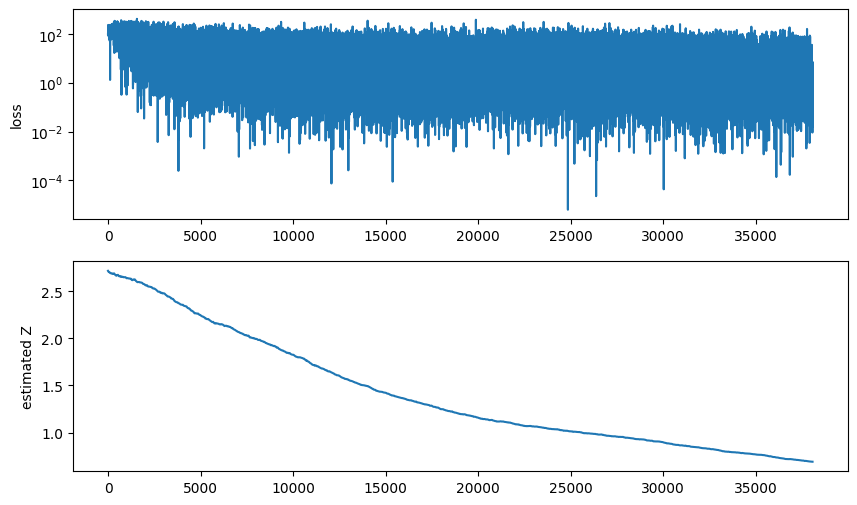

In [101]:
import matplotlib.pyplot as pp
import numpy as np

f, ax = pp.subplots(2, 1, figsize=(10, 6))
pp.sca(ax[0])
pp.plot(tb_losses)
pp.yscale("log")
pp.ylabel("loss")
pp.sca(ax[1])
pp.plot(np.exp(logZs))
pp.ylabel("estimated Z")

<Axes: >

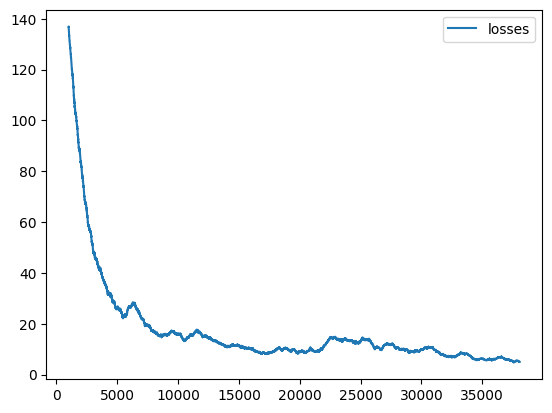

In [103]:
import pandas

pandas.DataFrame({"losses": tb_losses}).rolling(1000).mean().plot()

In [94]:
[decode_tictactoe_tensor(x) for x in sampled_faces[-120:]][14]

NameError: name 'sampled_faces' is not defined

In [104]:
 encoded_initial_board = encode_tictactoe_board(initial_board)
[ x.detach().numpy() for x in torch.split(tensor= torch.exp(model(encoded_initial_board)[0])/torch.exp(model(encoded_initial_board)[0]).sum(), split_size_or_sections=3) ]

[array([0.06647062, 0.04136873, 0.0241965 ], dtype=float32),
 array([0.01881094, 0.8124925 , 0.00642829], dtype=float32),
 array([0.02091741, 0.00533579, 0.00397915], dtype=float32)]

In [106]:
def get_new_board(board):
    encoded_board = encode_tictactoe_board(board)
    P_F_s, P_B_s = model(encoded_board)
    print(P_F_s)
    cat = Categorical(logits=P_F_s)
    action = cat.sample()
    new_board = encoded_board + torch.eye(9)[action]
    return decode_tictactoe_tensor(new_board)

In [108]:
board = [["X", " ", " "], ["X", " ", " "], ["O", "O", " "]]
get_new_board(board)

tensor([-100.0000,   -2.0994,    0.3046, -100.0000,    1.4106,   -1.9477,
        -100.0000, -100.0000,   -1.0191], grad_fn=<AddBackward0>)


[['X', ' ', ' '], ['X', 'X', ' '], ['O', 'O', ' ']]